In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ultimate-spotify-tracks-db:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F135088%2F566393%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240226%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240226T070324Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D32dd62b5e9fcd0f9d014d34c3a24024184a86d9d7b876b6e324b9b5db8ec05424d6fac2a4154e929357bbed30563f7b34d127287f8f4ff25180a34502bb38747e959a5ee33fd675eb4fc6ccb04f246c5482b0c725e5b39b4e48d7915014685790afd63c8f2565b79469574493b5e446aa2b540f476f9cfcec29c8873b2e5fcb8287e2ba0eb9c71de5fc45eb36e894d78fe6c9868ea770570af6b3c311aa6892745667ac9bff43e76cfc0674e17c1e4adef0d3ea13655dadbb57b2dc52ade75588409a255656f30fd0387f89e0aff659a32ef25205118f74b0009e0a5200b6bd2d4a2ba9e35080d222dd441d573f5f2e16a708c6b51485f2ed1952f384f4232eb,spotify-datasets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1641094%2F2695101%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240226%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240226T070324Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D92d1301a842083f5de781046f74bf07ed2835f33fd433abc69836ab37ec97e80f4a3d43272bfec539f20a57337085416c9f2626d5b81995c3c97dc167f18655deec7adb770a6041860d1ddb08a0d844053482c9bfdfce0af99e62dd3393ea88f78338943ecb64a516d71362d4f6a2bce801e4d9149a4ce93cf322c223c08aa62019e0850f89f0607f4b87923b969eac91ba99785879f1de44d5451fda86cbb8478be5c57a632c54d519c5dedc56f32d700bcdb0c33ff76637eb9c815daa26a263ce13cbb3be5338dabf65a586fd39c53bfc0657478e46efdfbc1bb20fe49596a6b468940c7563f8310c5a5c7cd74124edc475541ca05f46d21d2d7d7aab9bafb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16221953 bytes downloaded
Downloaded and uncompressed: ultimate-spotify-tracks-db
[==================================================] 86220009 bytes downloaded
Downloaded and uncompressed: spotify-datasets
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_t = pd.read_csv('/kaggle/input/spotify-datasets/tracks.csv')
df_t

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4


In [4]:
df_t.head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [5]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [6]:
df_t.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [7]:
df_t.isnull().sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

In [8]:
df_t.dropna(inplace = True)

In [9]:
sorted_df = df_t.sort_values('popularity',ascending=True).head(7)
sorted_df

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
134528,2hV7SShXsBeomXtpd53QNh,You and the night and the music,0,168098,0,"['Libby Holman & Her Orchestra', 'Libby Holman']","['1BJcpnHvZBZSgUBEch0utn', '08czVWdmLSEES9nLc4...",1934,0.306,0.171,4,-16.752,0,0.0374,0.981,0.000002,0.3720,0.352,127.261,5
132451,2heB3jEdRgx83180axN3cd,Roses of Picardy,0,162843,0,['Paul Specht'],['1tCrPspkGQyLDhWFmTZanI'],1923,0.324,0.495,5,-14.571,1,0.0336,0.978,0.760000,0.4060,0.702,207.380,4
132450,2ew5dyayICmi1B9DHhQhEh,I'm the last of the red hot mamas,0,118465,0,['Sophie Tucker'],['58nEgrqod6YO5ZATASjIQ8'],1923,0.607,0.319,0,-15.191,1,0.3580,0.996,0.577000,0.6640,0.795,84.080,4
132449,2baUvPSWFyxIkSUECmghxC,Snakes hips,0,190063,0,['The Georgians'],['58LQXzq5kNsvPQdviB4ZyL'],1923,0.640,0.541,3,-7.905,1,0.0384,0.996,0.879000,0.0853,0.844,98.589,4
132448,2ZTaPJ3LuOz4DC6nnoeTEv,The man I love,0,172905,0,"['Sophie Tucker', 'Miff Mole']","['58nEgrqod6YO5ZATASjIQ8', '1WZqArTg7JOsXScvGF...",1923,0.487,0.163,8,-15.863,1,0.0449,0.992,0.000041,0.0702,0.502,109.412,5
132447,2Rfr8KkJOYpir4uaTKrowo,I'll Have Vanilla,0,191970,0,['Eddie Cantor'],['2pDFdLHKOmzKiNDzkz7p8L'],1923,0.636,0.326,0,-11.082,0,0.0462,0.983,0.000010,0.3880,0.673,110.490,4
132446,2PQzuSpu8fyEIm1RWafECX,Little Curly Hair In a High Chair,0,193459,0,"['Jerry Joyce', 'Eddie Cantor']","['1t8J6SE9IOemeQWADZZSax', '2pDFdLHKOmzKiNDzkz...",1923,0.325,0.152,6,-15.167,1,0.0390,0.988,0.009300,0.4240,0.320,87.750,4


In [10]:
df_t.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
popularity,586601.0,27.573212,18.369417,0.0,13.0000,27.000000,41.00000,100.000
duration_ms,586601.0,230054.852626,126532.824981,3344.0,175083.0000,214907.000000,263867.00000,5621218.000
explicit,586601.0,0.044091,0.205298,0.0,0.0000,0.000000,0.00000,1.000
danceability,586601.0,0.563612,0.166101,0.0,0.4530,0.577000,0.68600,0.991
energy,586601.0,0.542071,0.251910,0.0,0.3430,0.549000,0.74800,1.000
key,586601.0,5.221594,3.519420,0.0,2.0000,5.000000,8.00000,11.000
loudness,586601.0,-10.205789,5.089422,-60.0,-12.8910,-9.242000,-6.48100,5.376
mode,586601.0,0.658797,0.474114,0.0,0.0000,1.000000,1.00000,1.000
speechiness,586601.0,0.104870,0.179902,0.0,0.0340,0.044300,0.07630,0.971
acousticness,586601.0,0.449803,0.348812,0.0,0.0969,0.422000,0.78400,0.996


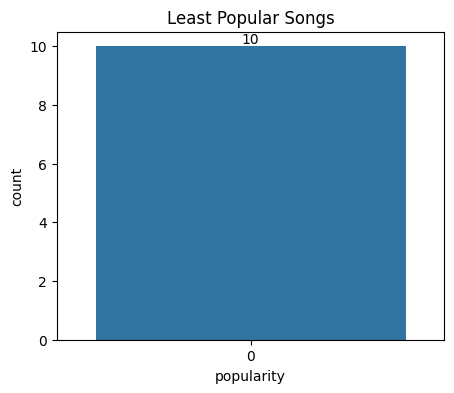

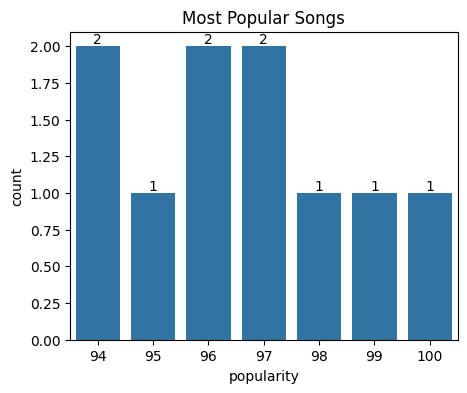

In [11]:
#Exploratory Data Analysis

#Question 1: Find the 10 most and least popular songs.
least_popular_songs = df_t.sort_values('popularity',ascending = True).head(10)   #sorting the values and then plotting them on a graph.
least_popular_songs
plt.figure(figsize = (5,4))
ax = sns.countplot(data = least_popular_songs, x = 'popularity')
plt.title('Least Popular Songs')
for bars in ax.containers:
    ax.bar_label(bars)
#most popular songs
most_popular_songs = df_t.query('popularity > 90').sort_values('popularity', ascending = False).head(10)
most_popular_songs          #sorting the values and then plotting them on a graph.
plt.figure(figsize = (5,4))
ax = sns.countplot(data = most_popular_songs, x = 'popularity')
plt.title('Most Popular Songs')
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

In [12]:
# Ten Popular Songs With Popularity More Than 90.
most_popular=df_t.query('popularity>90',inplace=False).sort_values('popularity',ascending=False)
most_popular[:10]


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
93802,4iJyoBOLtHqaGxP12qzhQI,Peaches (feat. Daniel Caesar & Giveon),100,198082,1,"['Justin Bieber', 'Daniel Caesar', 'Giveon']","['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...",2021-03-19,0.677,0.696,0,-6.181,1,0.1190,0.32100,0.000000,0.4200,0.464,90.030,4
93803,7lPN2DXiMsVn7XUKtOW1CS,drivers license,99,242014,1,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],2021-01-08,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,4
93804,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,98,132780,0,['Masked Wolf'],['1uU7g3DNSbsu0QjSEqZtEd'],2021-01-06,0.778,0.695,4,-6.865,0,0.0913,0.17500,0.000000,0.1500,0.472,149.996,4
92810,5QO79kh1waicV47BqGRL3g,Save Your Tears,97,215627,1,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,4
92811,6tDDoYIxWvMLTdKpjFkc1B,telepatía,97,160191,0,['Kali Uchis'],['1U1el3k54VvEUzo3ybLPlM'],2020-12-04,0.653,0.524,11,-9.016,0,0.0502,0.11200,0.000000,0.2030,0.553,83.970,4
92813,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,96,200040,0,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4
93805,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,96,242096,0,"['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']","['0du5cEVh5yTK9QJze8zA0C', '3jK9MiCrA42lLAdMGU...",2021-03-05,0.586,0.616,5,-7.964,1,0.0324,0.18200,0.000000,0.0927,0.719,148.088,4
92814,6f3Slt0GbA2bPZlz0aIFXN,The Business,95,164000,0,['Tiësto'],['2o5jDhtHVPhrJdv3cEQ99Z'],2020-09-16,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.1120,0.235,120.031,4
91866,60ynsPSSKe6O3sfwRnIBRf,Streets,94,226987,1,['Doja Cat'],['5cj0lLjcoR7YOSnhnX0Po5'],2019-11-07,0.749,0.463,11,-8.433,1,0.0828,0.20800,0.037100,0.3370,0.190,90.028,4
92816,3FAJ6O0NOHQV8Mc5Ri6ENp,Heartbreak Anniversary,94,198371,0,['Giveon'],['4fxd5Ee7UefO4CUXgwJ7IP'],2020-03-27,0.449,0.465,0,-8.964,1,0.0791,0.52400,0.000001,0.3030,0.543,89.087,3


In [13]:
#Find the Name of the Artist Present in the 18th Row of the Dataset.
df_t[["artists"]].iloc[18]

artists    ['Victor Boucher']
Name: 18, dtype: object

In [14]:
#Make the Release Date Column as the Index Column.
df_t.set_index("release_date",inplace=True)
df_t.index=pd.to_datetime(df_t.index)
df_t.head(6)

,id,name,popularity,duration_ms,explicit,artists,id_artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
release_date,,,,,,,,,,,,,,,,,,,
1922-02-22,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.1510,0.1270,104.851,3
1922-06-01,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.1480,0.6550,102.009,1
1922-03-21,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.2120,0.4570,130.418,5
1922-03-21,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.1040,0.3970,169.980,3
1922-01-01,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.3110,0.1960,103.220,4
1922-01-01,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],0.227,0.2610,5,-12.343,1,0.0382,0.994,0.2470,0.0977,0.0539,118.891,4


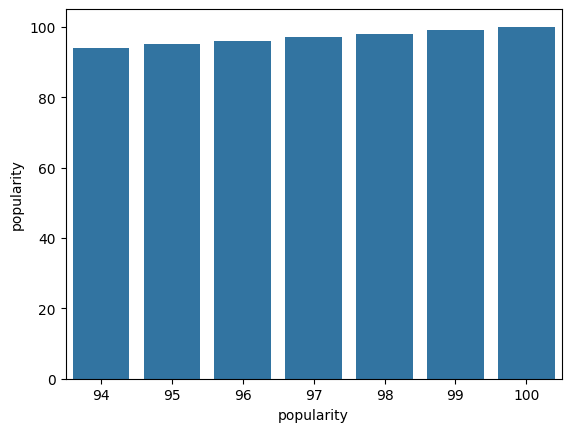

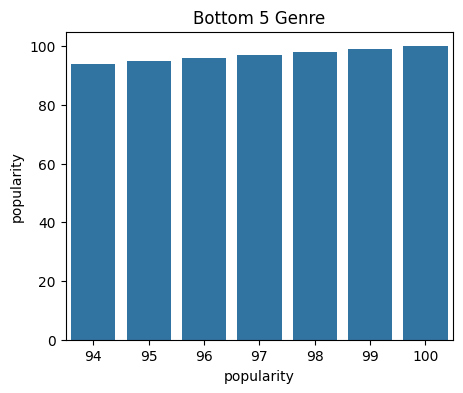

In [18]:
#Question 2: What are the bottom 5 Genre?
!pip install seaborn
import seaborn as sns
bottom_5 = df_t.sort_values('popularity', ascending = True).tail(10)
sns.barplot(data = bottom_5, x = 'popularity', y = 'popularity')
plt.figure(figsize = (5,4))
plt.title("Bottom 5 Genre")

sns.barplot(data = bottom_5, x = 'popularity', y = 'popularity')
plt.show()


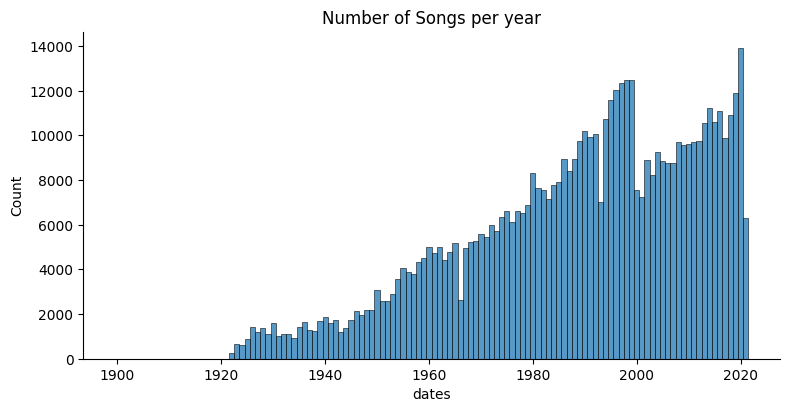

In [19]:
#Question 3: Find total number of songs produced from the 1st year of production.
df_t['dates'] = df_t.index.get_level_values('release_date')
df_t.dates = pd.to_datetime(df_t.dates)
years = df_t.dates.dt.year
sns.displot(years, discrete = True, aspect = 2, height = 4, kind = 'hist')
plt.title('Number of Songs per year')
plt.show()


In [24]:
#Convert the Duration of the Songs From Milliseconds to Seconds.

In [21]:
import pandas as pd
df_t["duration"] = df_t["duration_ms"].apply(lambda x: round(x/1000))
df_t.drop("duration_ms", inplace=True, axis=1)
df_t.duration.head(6)

release_date
1922-02-22    127
1922-06-01     98
1922-03-21    182
1922-03-21    177
1922-01-01    163
1922-01-01    179
Name: duration, dtype: int64

In [27]:
#Correlation Map

[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'danceability'),
 Text(2.5, 0, 'energy'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'speechiness'),
 Text(5.5, 0, 'acousticness'),
 Text(6.5, 0, 'instrumentalness'),
 Text(7.5, 0, 'liveness'),
 Text(8.5, 0, 'valence'),
 Text(9.5, 0, 'tempo'),
 Text(10.5, 0, 'time_signature'),
 Text(11.5, 0, 'duration')]

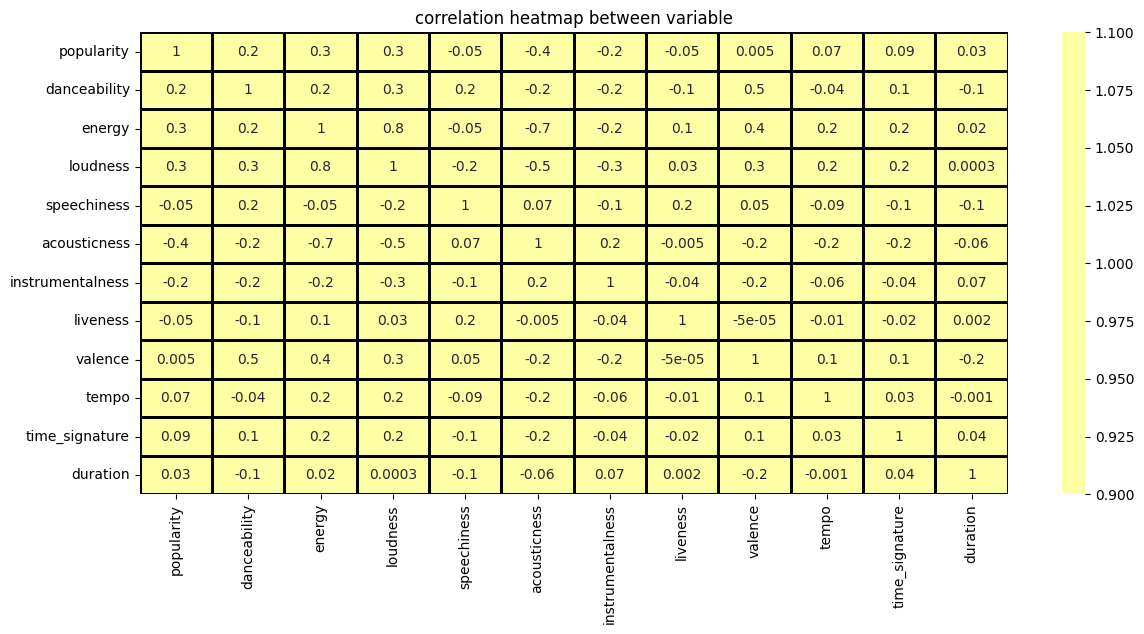

In [26]:
corr_df=df_t.drop(["key","mode","explicit"],axis=1).corr(method="pearson")
plt.figure(figsize=(14,6))
heatmap=sns.heatmap(corr_df,annot=True,fmt=".1g",vmin=1,vmax=1,center=0,cmap="inferno",linewidths=1,linecolor="black")
heatmap.set_title("correlation heatmap between variable")
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90)

In [28]:
#Let’s Move Ahead and Sample Only 4 Percent of the Whole Dataset.
sample_df=df_t.sample(int(0.004*len(df_t)))
print(len(sample_df))

2346


In [ ]:
#Create a Regression Plot Between Popularity and Acousticness in the Form of a Regression Line.

[Text(0.5, 1.0, 'Popularity vs Acousticness correlation')]

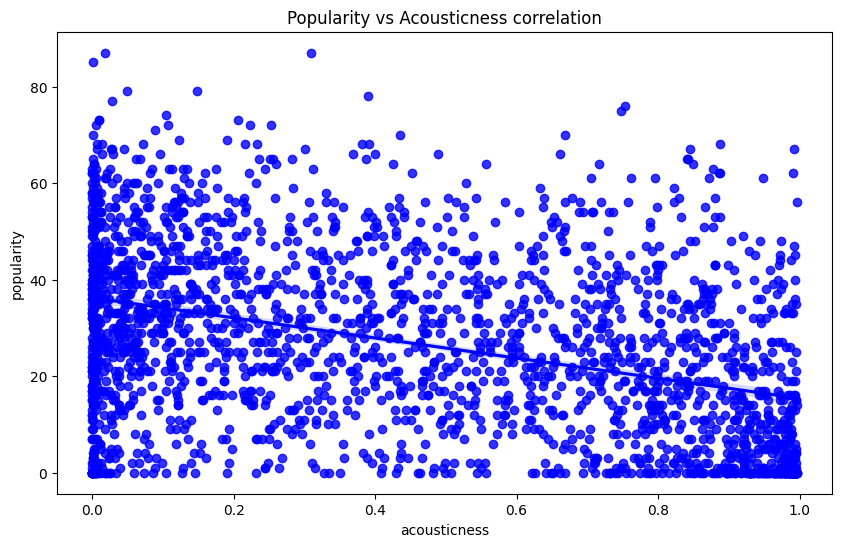

In [41]:
plt.figure(figsize=(10,6))
sns.regplot(data=sample_df,y = "popularity", x = "acousticness",color="b").set(title="Popularity vs Acousticness correlation")

Text(0.5, 1.0, 'Loudness vs Energy correlation')

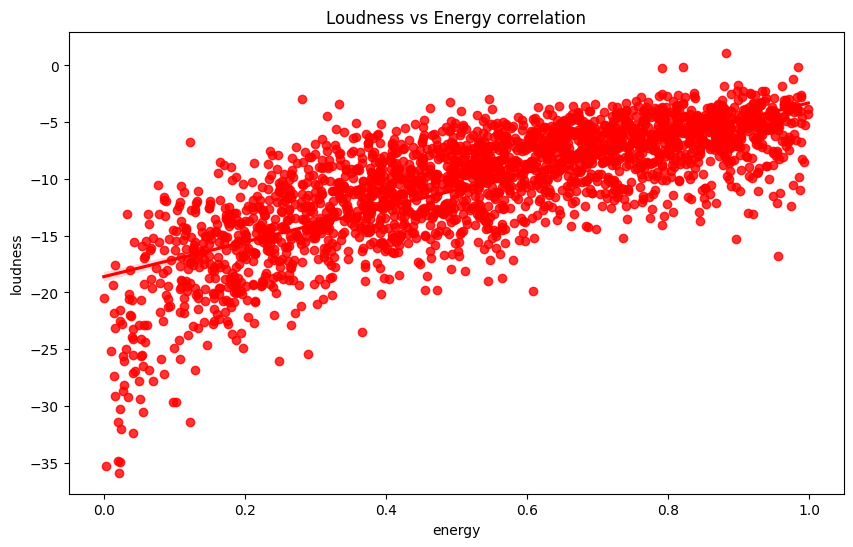

In [43]:
!pip install seaborn
!pip install colorcet
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y="loudness", x="energy", color="r")
plt.title("Loudness vs Energy correlation")

In [44]:
df_t["dates"]=df_t.index.get_level_values('release_date')
df_t_dates=pd.to_datetime(df_t.dates)
years=df_t.dates.dt.year

(array([1880., 1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 [Text(1880.0, 0, '1880'),
  Text(1900.0, 0, '1900'),
  Text(1920.0, 0, '1920'),
  Text(1940.0, 0, '1940'),
  Text(1960.0, 0, '1960'),
  Text(1980.0, 0, '1980'),
  Text(2000.0, 0, '2000'),
  Text(2020.0, 0, '2020'),
  Text(2040.0, 0, '2040')])

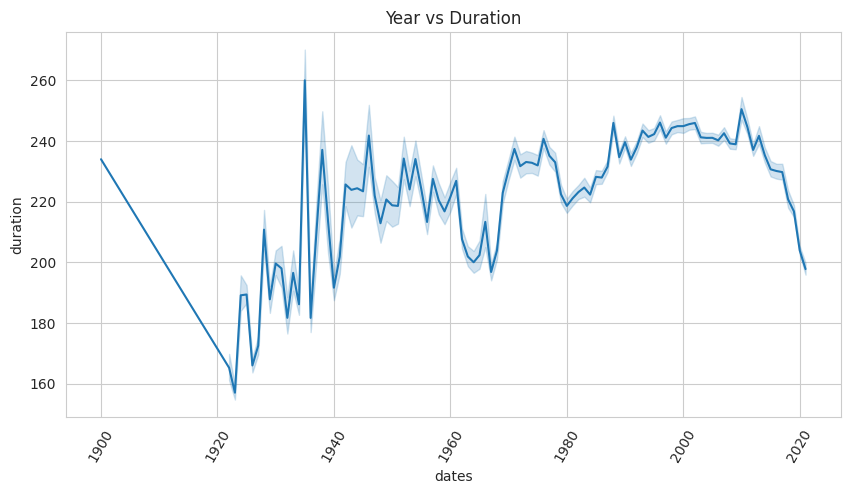

In [46]:
import seaborn as sns
sns.set_style(style="whitegrid")
total_dr=df_t.duration
import seaborn as sns
sns.set_style(style="whitegrid")
fig_dims=(10,5)
fig,ax=plt.subplots(figsize=fig_dims)
fig=sns.lineplot(x=years ,y=total_dr,ax=ax).set(title="Year vs Duration")
plt.xticks(rotation=60)